In [1]:
%matplotlib inline

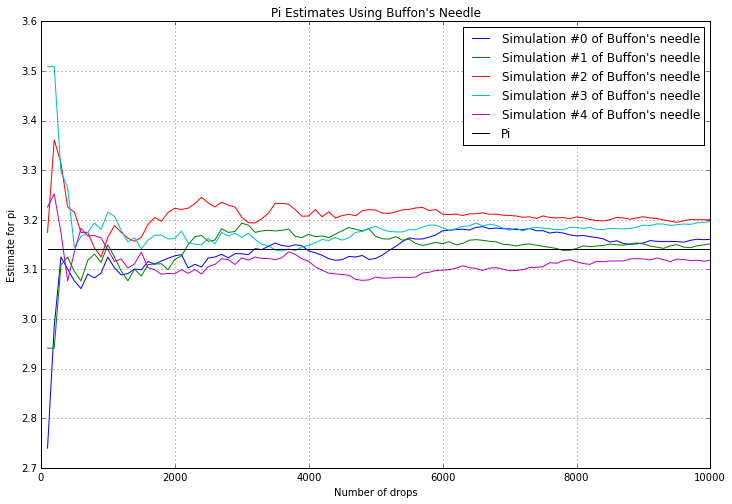

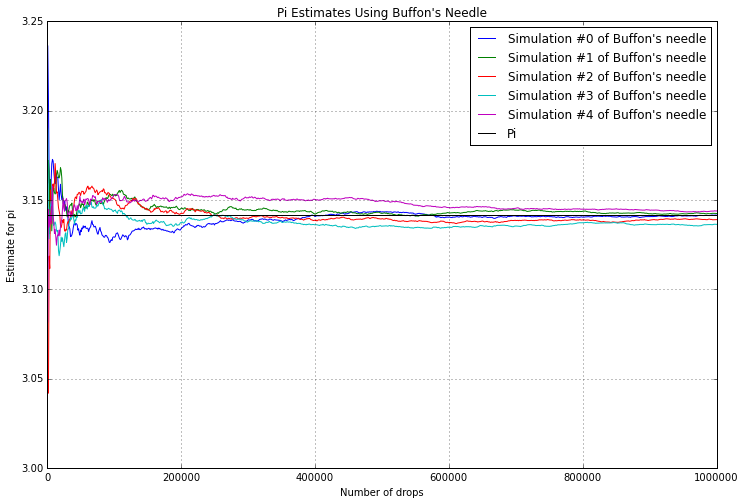

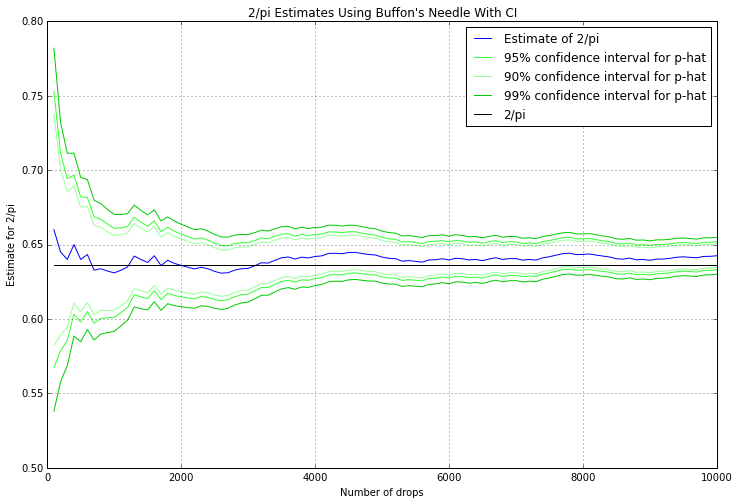

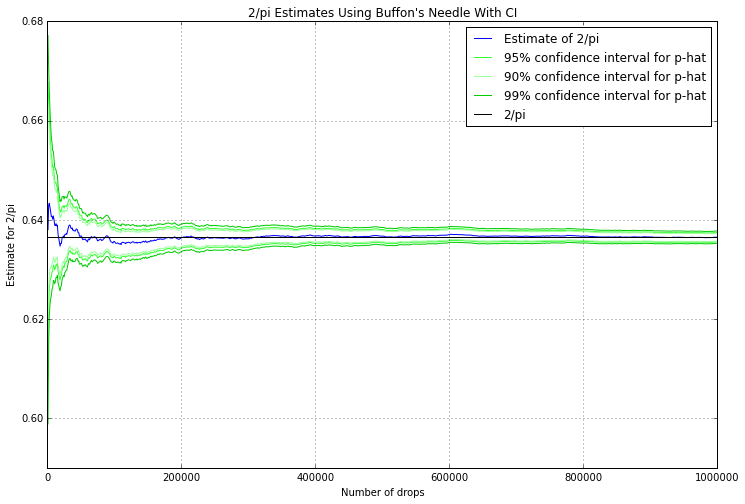

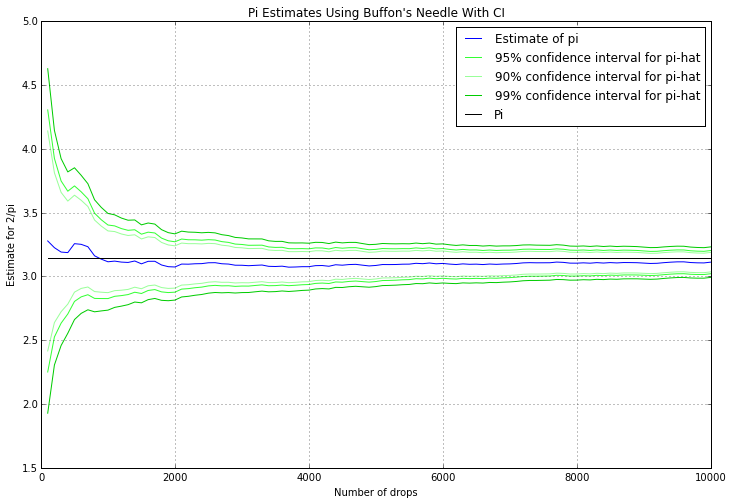

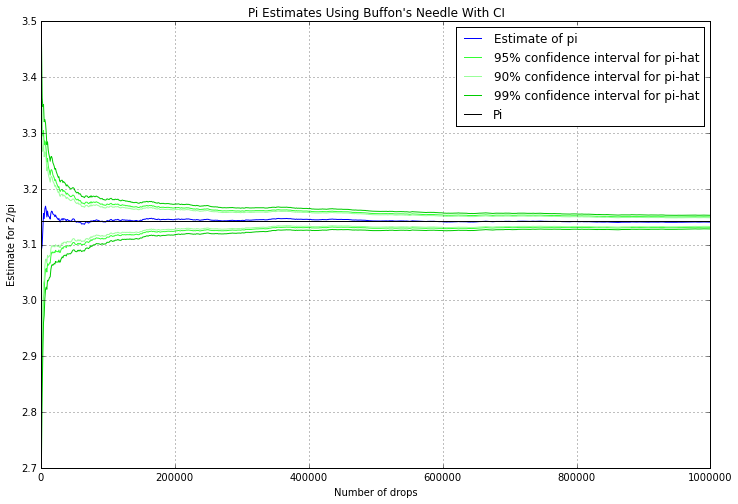

In [25]:
from numpy import random, pi, sin
from scipy.stats import norm
import matplotlib.pyplot as plt

def drop_needle():
    """
    To estimate a single drop, it is sufficient to randomize a 
    location one end is dropped upon (between 0 and 1),
    an angle at which it is dropped, 
    and to then check if it crosses either 0 or 1.

    :return: True if the simulated needle crossed a line, False otherwise
    """
    start = random.uniform()
    angle = random.uniform() * 2 * pi
    end = start + sin(angle)

    return end <= 0 or end >= 1


def pi_from_simulation_results(drops, hits):
    """
    Estimate pi from simulation results
    :param drops: the number of drops performed
    :param hits: the number of hits observed in simulation
    :return: the estimation for pi from these results
    """
    return 2.0 * drops / hits


def buffons_needle_approximation(n):
    """
    Estimate pi using Buffon's needle procedure
    :param n: the number of needles to drop
    :return: the approximation of pi from those drops
    """
    hits = 0
    for _ in xrange(n):
        hits += drop_needle()

    return pi_from_simulation_results(n, hits)


def consecutive_buffons_needle_pi_approximation(n_values):
    """
    Running estimate of pi using Buffon's needle procedure, 
    yielding values at every point in n_values
    :param n_values: the values of n to yield in
    :return: the approximation of pi from each n value drops
    """
    n = 0
    hits = 0

    for next_n in n_values:
        while n < next_n:
            hits += drop_needle()
            n += 1

        yield pi_from_simulation_results(n, hits)
        

def consecutive_two_over_pi_approximation(n_values):
    """
    Running estimate of two/pi (the original proportion) 
    using Buffon's needle procedure, 
    yielding values at every point in n_values
    :param n_values: the values of n to yield in
    :return: the approximation of two/pi from each n value drops
    """
    n = 0
    hits = 0

    for next_n in n_values:
        while n < next_n:
            hits += drop_needle()
            n += 1

        yield float(hits)/n

        
def graph_consecutive_drops(n_values, number_of_simulations=3):
    plt.figure(figsize=(12, 8), dpi=400)
    
    for simulation in xrange(number_of_simulations):
        estimates = \
            [est for est in consecutive_buffons_needle_pi_approximation(n_values)]    
        plt.plot(n_values, estimates, 
                 label="Simulation #{sim} of Buffon's needle".format(sim=simulation))

    plt.plot(n_values, [pi] * len(n_values), color='black', label="Pi")
    
    plt.grid(True)
    plt.title("Pi Estimates Using Buffon's Needle")
    plt.xlabel("Number of drops")
    plt.ylabel("Estimate for pi")
    plt.legend()
    
    plt.show()
    
def graph_two_over_pi_with_confidence(n_values):
    plt.figure(figsize=(12, 8), dpi=400)
    
    p_estimates = \
        [est for est in consecutive_two_over_pi_approximation(n_values)]    
    plt.plot(n_values, p_estimates, label="Estimate of 2/pi")
    
    for alpha in ALPHA_LEVELS:
        pos, neg = generate_two_over_pi_confidence_interval(n_values, p_estimates, alpha)
        plt.plot(n_values, pos, color=ALPHA_LEVELS[alpha], 
                label='{alpha:.0%} confidence interval for p-hat'.format(alpha=alpha))
        plt.plot(n_values, neg, color=ALPHA_LEVELS[alpha])

    plt.plot(n_values, [2.0 / pi] * len(n_values), color='black', label="2/pi")
    
    plt.grid(True)
    plt.title("2/pi Estimates Using Buffon's Needle With CI")
    plt.xlabel("Number of drops")
    plt.ylabel("Estimate for 2/pi")
    plt.legend()
    
    plt.show()
        

def generate_two_over_pi_confidence_interval(n_values, p_estimates, alpha):
    positive_half = []
    negative_half = []
    
    z = z_star(alpha)
    for i in xrange(len(n_values)):
        p_hat = p_estimates[i]
        interval =  z * (p_hat * (1 - p_hat) / n_values[i]) ** 0.5 
        positive_half.append(p_hat + interval)
        negative_half.append(p_hat - interval)
    
    return positive_half, negative_half


def graph_pi_with_confidence(n_values):
    plt.figure(figsize=(12, 8), dpi=400)
    
    pi_estimates = \
        [est for est in consecutive_buffons_needle_pi_approximation(n_values)]    
    plt.plot(n_values, pi_estimates, label="Estimate of pi")
    
    for alpha in ALPHA_LEVELS:
        pos, neg = generate_pi_confidence_interval(n_values, pi_estimates, alpha)
        plt.plot(n_values, pos, color=ALPHA_LEVELS[alpha], 
                label='{alpha:.0%} confidence interval for pi-hat'.format(alpha=alpha))
        plt.plot(n_values, neg, color=ALPHA_LEVELS[alpha])

    plt.plot(n_values, [pi] * len(n_values), color='black', label="Pi")
    
    plt.grid(True)
    plt.title("Pi Estimates Using Buffon's Needle With CI")
    plt.xlabel("Number of drops")
    plt.ylabel("Estimate for 2/pi")
    plt.legend()
    
    plt.show()


def generate_pi_confidence_interval(n_values, pi_estimates, alpha):
    positive_half = []
    negative_half = []
    
    z = z_star(alpha)
    for i in xrange(len(n_values)):
        pi_hat = pi_estimates[i]
        interval =  z * ( (pi_hat - 2) * 2 * (pi_hat ** 2) / n_values[i] ) ** 0.5 
        positive_half.append(pi_hat + interval)
        negative_half.append(pi_hat - interval)
    
    return positive_half, negative_half
        

ALPHA_LEVELS = {0.9: '#99FF99', 0.95: '#33FF33', 0.99: '#00CC00'}
N_VALUES = (100, 1000, 10000, 100000)
     

def z_star(alpha):
    return norm.interval(alpha)[1]

    
def theoretical_two_over_pi_stddev_and_confidence_intervals(n):
    """
    Returns an output helping to build the latex tables for the theoretical CIs
    """
    stddev = ( (pi - 2) * 2 / (n * (pi ** 2)) ) ** 0.5
    output = ['{n}'.format(n=n), '{stddev:.4f}'.format(stddev=stddev)]
    
    for alpha in ALPHA_LEVELS:
        output.append(r'$\frac{2}{\pi} \pm ' + '{x:.4f}'
                      .format(x=(z_star(alpha) * stddev)) + '$')
    
    return ' & '.join(output) + r' \\'


def theoretical_pi_stddev_and_confidence_intervals(n):
    """
    Returns an output helping to build the latex tables for the theoretical CIs
    """
    stddev = ( (pi - 2) * 2 * (pi ** 2) / n ) ** 0.5
    output = ['{n}'.format(n=n), '{stddev:.4f}'.format(stddev=stddev)]
    
    for alpha in ALPHA_LEVELS:
        output.append(r'$\pi \pm ' + '{x:.4f}'
                      .format(x=(z_star(alpha) * stddev)) + '$')
    
    return ' & '.join(output) + r' \\'

        
def main():
    graph_consecutive_drops([100 * x for x in xrange(1, 101)], 5)
    graph_consecutive_drops([1000 * x for x in xrange(1, 1001)], 5)

    graph_two_over_pi_with_confidence([100 * x for x in xrange(1, 101)])
    graph_two_over_pi_with_confidence([1000 * x for x in xrange(1, 1001)])

    graph_pi_with_confidence([100 * x for x in xrange(1, 101)])
    graph_pi_with_confidence([1000 * x for x in xrange(1, 1001)])
    
        # Generate latex tables:
#     for n in N_VALUES:
#         print theoretical_two_over_pi_stddev_and_confidence_intervals(n)
#     for n in N_VALUES:
#         print theoretical_pi_stddev_and_confidence_intervals(n)

if __name__ == '__main__':
    main()